In [24]:
import pandas as pd
from db import Database

In [25]:
train = pd.read_csv("Database.csv")
train.head()

,Unnamed: 0,page,idx,year,method,area,st_price,final_price,auction_year,auction_month,auction_date
0,0,0,0,NaN,gouache and colored pencil on paper,784.00,15000000,15000000.0,2021,9,28
1,1,0,1,1961,gouache on paper,1056.25,120000000,120000000.0,2021,9,28
2,2,0,2,1968,color on newspaper,3058.09,80000000,80000000.0,2021,9,28
3,3,0,3,1971,oil on Korean paper,3192.25,80000000,80000000.0,2021,9,28
4,4,0,4,NaN,oil on canvas,2043.04,300000000,300000000.0,2021,9,28


In [26]:
train.final_price.describe()

count    4.290000e+02
mean     3.553226e+08
std      9.064486e+08
min      0.000000e+00
25%      2.200000e+07
50%      7.576392e+07
75%      2.950000e+08
max      9.394726e+09
Name: final_price, dtype: float64

In [27]:
train.isnull().sum()

Unnamed: 0         0
page               0
idx                0
year             127
method             7
area               0
st_price           0
final_price        0
auction_year       0
auction_month      0
auction_date       0
dtype: int64

In [28]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [29]:
# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [30]:
font_path = "C:/Windows/Fonts/H2GTRM.TTF"
font = mpl.font_manager.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font)

[Text(0.5, 0, 'auction_year'), Text(0.5, 1.0, '경매년도')]

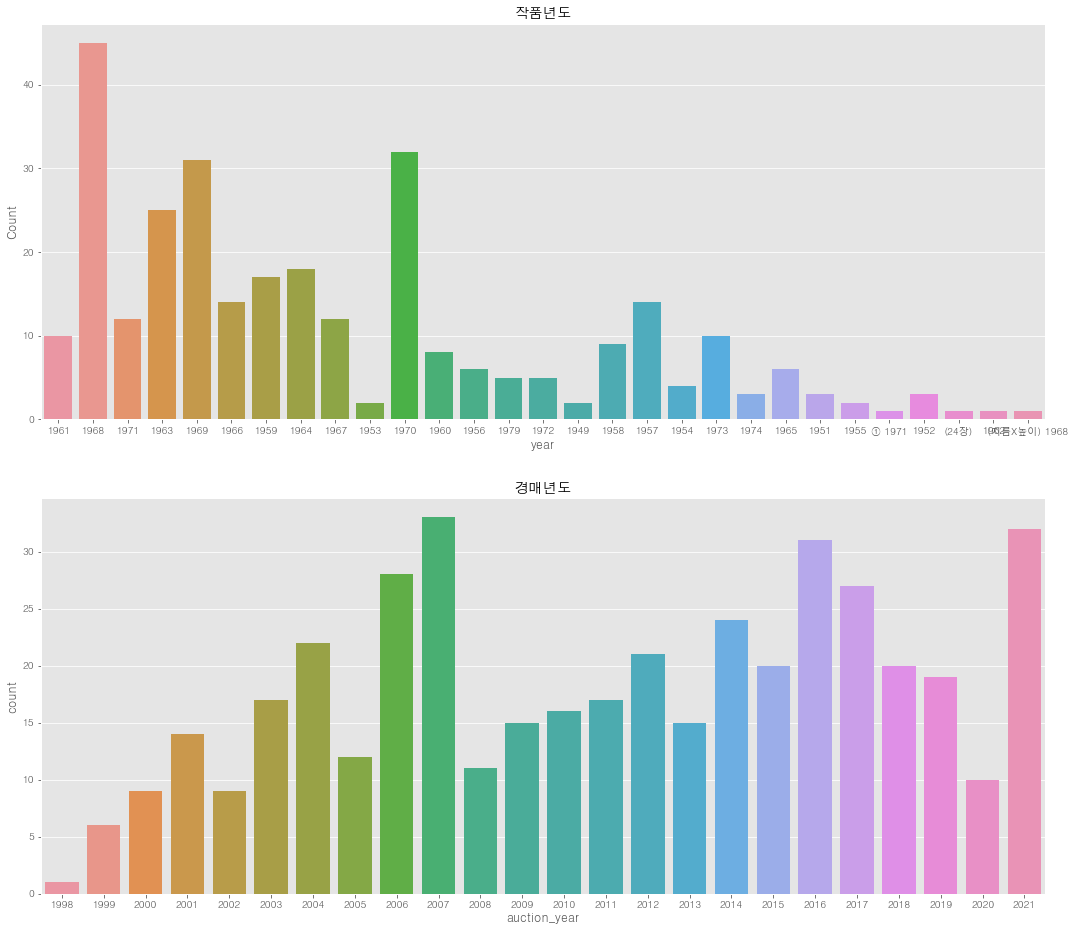

In [31]:
import seaborn as sns
from scipy import stats

figure, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18,16)

sns.countplot(data=train, x="year", ax=ax1)
sns.countplot(data=train, x="auction_year", ax=ax2)

ax1.set(ylabel='Count',xlabel='year',title="작품년도")
ax2.set(xlabel='auction_year',title="경매년도")

In [32]:
figure.savefig('savefig_default.png')

[Text(0.5, 0, 'year'), Text(0, 0.5, 'area'), Text(0.5, 1.0, '작품년도별 크기')]

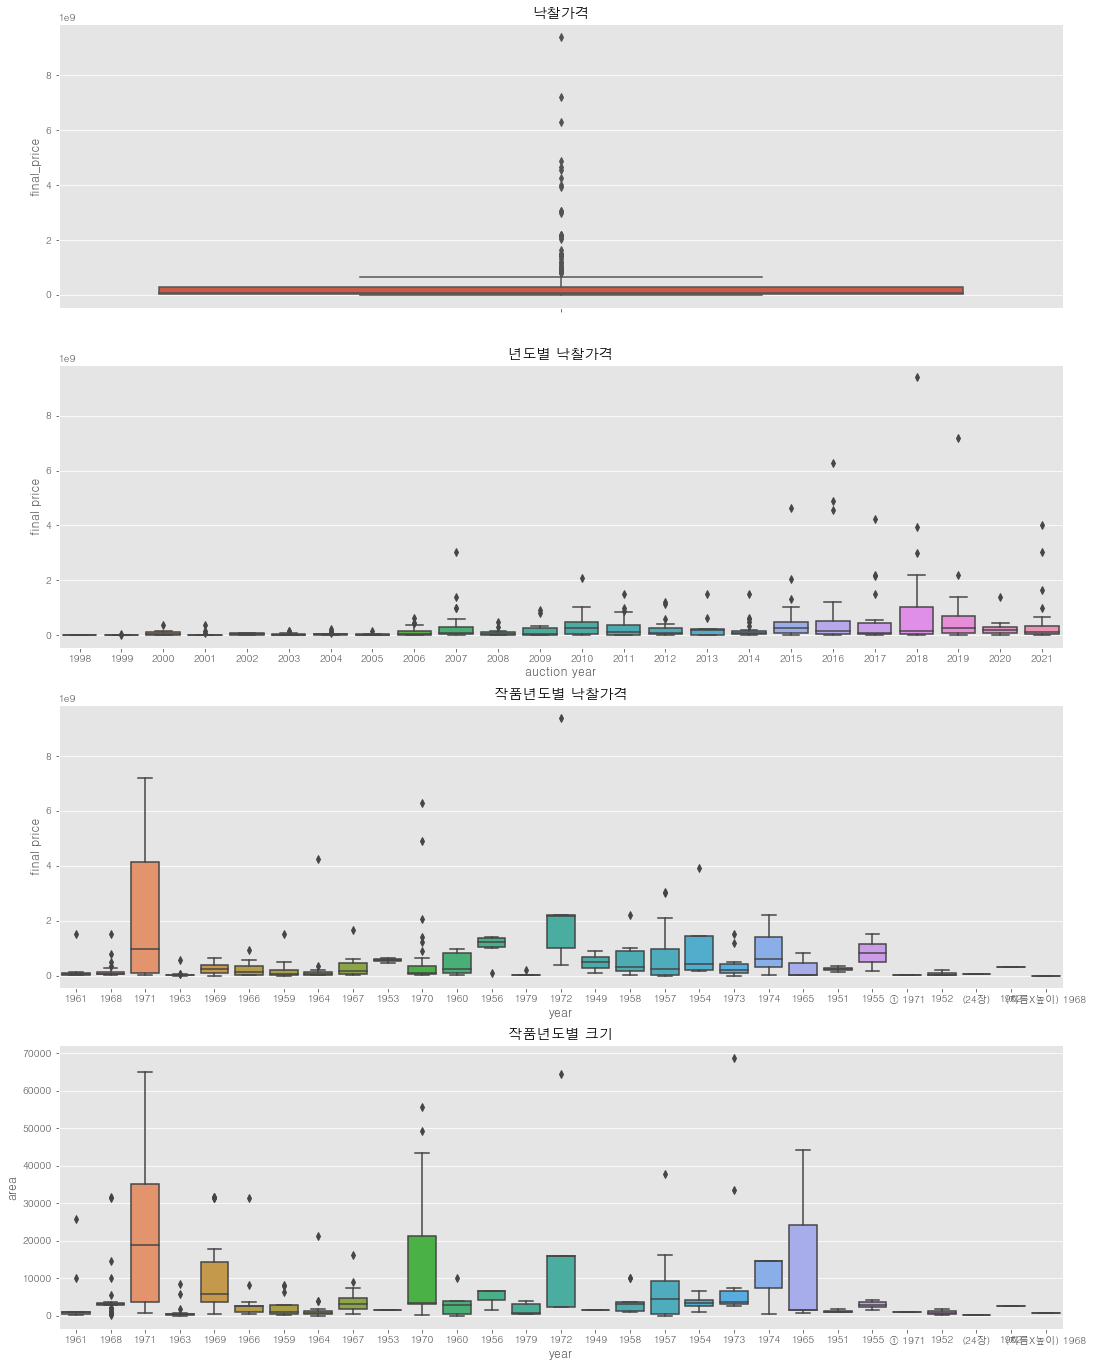

In [33]:
fig, axes = plt.subplots(nrows=4,ncols=1)
fig.set_size_inches(18, 24)

sns.boxplot(data=train,y="final_price",orient="v",ax=axes[0])
sns.boxplot(data=train,y="final_price",x="auction_year",orient="v",ax=axes[1])
sns.boxplot(data=train,y="final_price",x="year",orient="v",ax=axes[2])
sns.boxplot(data=train,y="area",x="year",orient="v",ax=axes[3])


axes[0].set(ylabel='final_price',title="낙찰가격")
axes[1].set(xlabel='auction year', ylabel='final price',title="년도별 낙찰가격")
axes[2].set(xlabel='year', ylabel='final price',title="작품년도별 낙찰가격")
axes[3].set(xlabel='year', ylabel='area',title="작품년도별 크기")

In [34]:
def concatenate_year_month(data):
    return "{0}-{1}".format(data['auction_year'], data['auction_month'])

train["year_month"] = train.apply(concatenate_year_month,axis=1)

print(train.shape)
train[["year_month"]].head()

(429, 12)


,year_month
0,2021-9
1,2021-9
2,2021-9
3,2021-9
4,2021-9


[Text(0.5, 0, 'auction time'),
 Text(0, 0.5, 'final price'),
 Text(0.5, 1.0, '시간별 낙찰가격')]

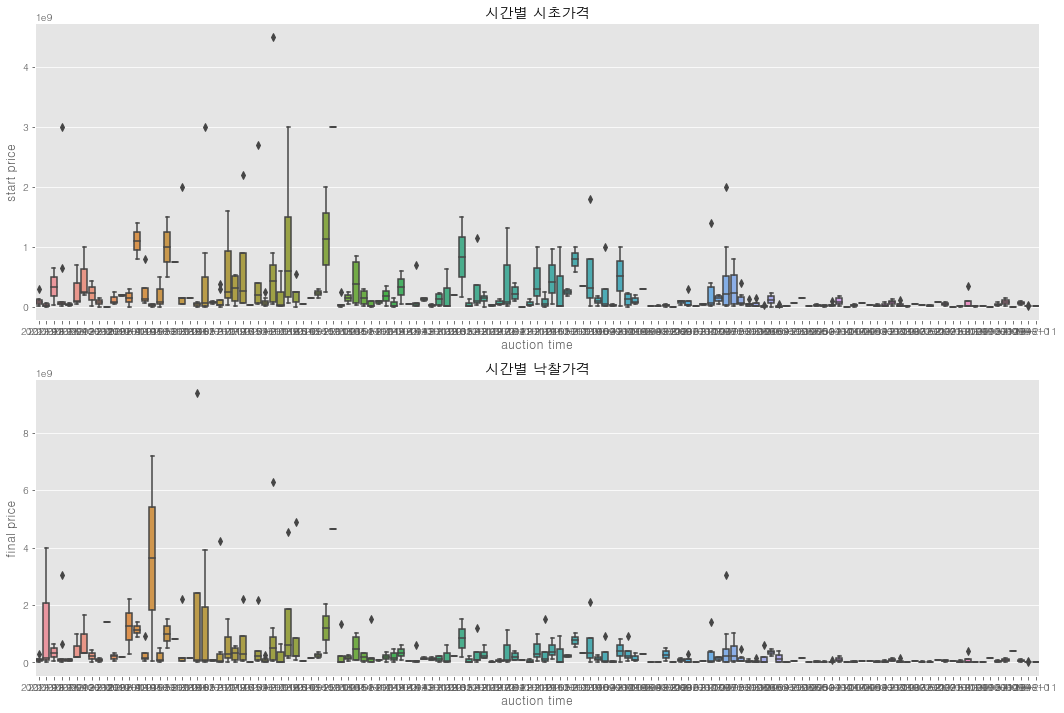

In [35]:
fig, axes = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(18, 12)

sns.boxplot(data=train,y="st_price",x="year_month",orient="v",ax=axes[0])
sns.boxplot(data=train,y="final_price",x="year_month",orient="v",ax=axes[1])

axes[0].set(xlabel='auction time', ylabel='start price',title="시간별 시초가격")
axes[1].set(xlabel='auction time', ylabel='final price',title="시간별 낙찰가격")

In [36]:
def price_rise(data):
    return data['final_price']-data['st_price']

def price_rise_rate(data):
    if data['st_price'] != 0:
        return (data['final_price']-data['st_price'])/data['st_price']
    else:
        return 0

train["price_rise"] = train.apply(price_rise,axis=1)
train["price_rise_rate"] = train.apply(price_rise_rate,axis=1)
# train['price_rise'].head()
train['price_rise_rate'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: price_rise_rate, dtype: float64

[Text(0.5, 0, 'auction year'),
 Text(0, 0.5, 'price rise rate'),
 Text(0.5, 1.0, '년도별 낙찰가격상승률'),
 (0.0, 5.0)]

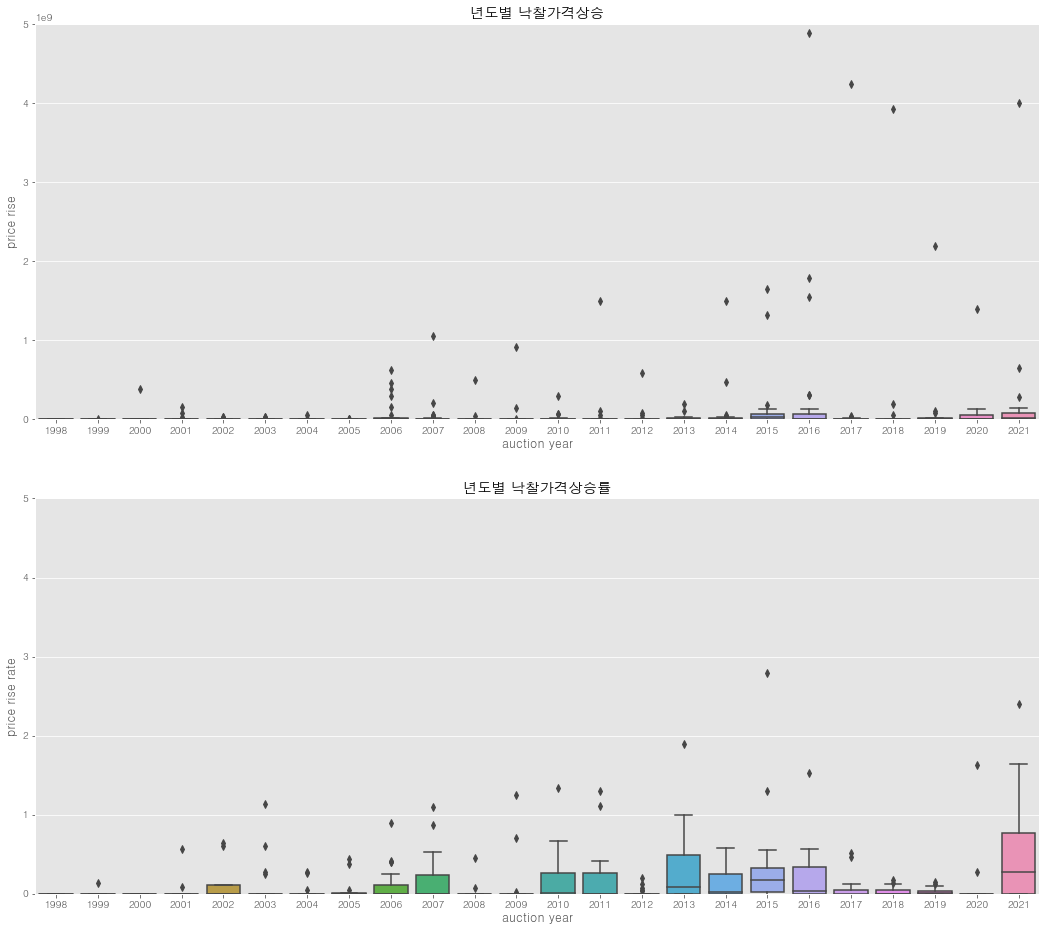

In [37]:
fig, axes = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(18, 16)

sns.boxplot(data=train,y="price_rise",x="auction_year",orient="v",ax=axes[0])
sns.boxplot(data=train,y="price_rise_rate",x="auction_year",orient="v",ax=axes[1])

axes[0].set(xlabel='auction year', ylabel='price rise', title="년도별 낙찰가격상승",ylim=(0,0.5e10))
axes[1].set(xlabel='auction year', ylabel='price rise rate',title="년도별 낙찰가격상승률",ylim=(0,5))


In [38]:
fig.savefig('savefig_년도별낙찰가격상승.png')

In [39]:
def concatenate_year_month(data):
    return (data['auction_year']//10)*10

train["10year"] = train.apply(concatenate_year_month,axis=1)

print(train.shape)
train[["10year"]].head()

(429, 15)


,10year
0,2020
1,2020
2,2020
3,2020
4,2020


[Text(0.5, 0, 'years'),
 Text(0, 0.5, 'price rise rate'),
 Text(0.5, 1.0, '시대별 낙찰가격상승률'),
 (0.0, 5.0)]

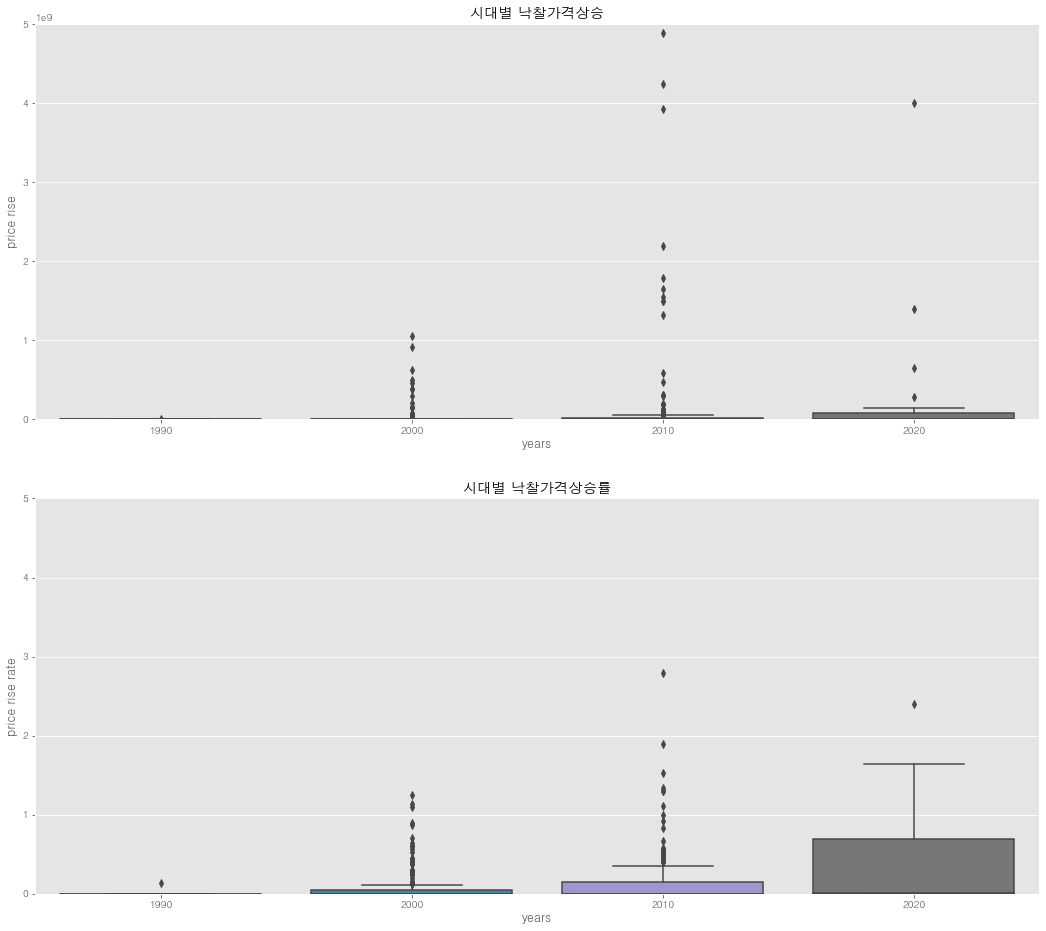

In [40]:
fig, axes = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(18, 16)

sns.boxplot(data=train,y="price_rise",x="10year",orient="v",ax=axes[0])
sns.boxplot(data=train,y="price_rise_rate",x="10year",orient="v",ax=axes[1])

axes[0].set(xlabel='years', ylabel='price rise', title="시대별 낙찰가격상승",ylim=(0,0.5e10))
axes[1].set(xlabel='years', ylabel='price rise rate',title="시대별 낙찰가격상승률",ylim=(0,5))


In [41]:
def concatenate_year_month(data):
    return (data['auction_year']//5)*5

train["5year"] = train.apply(concatenate_year_month,axis=1)

print(train.shape)
train[["5year"]].head()

(429, 16)


,5year
0,2020
1,2020
2,2020
3,2020
4,2020


[Text(0.5, 0, 'years'),
 Text(0, 0.5, 'price rise rate'),
 Text(0.5, 1.0, '시대별 낙찰가격상승률'),
 (0.0, 5.0)]

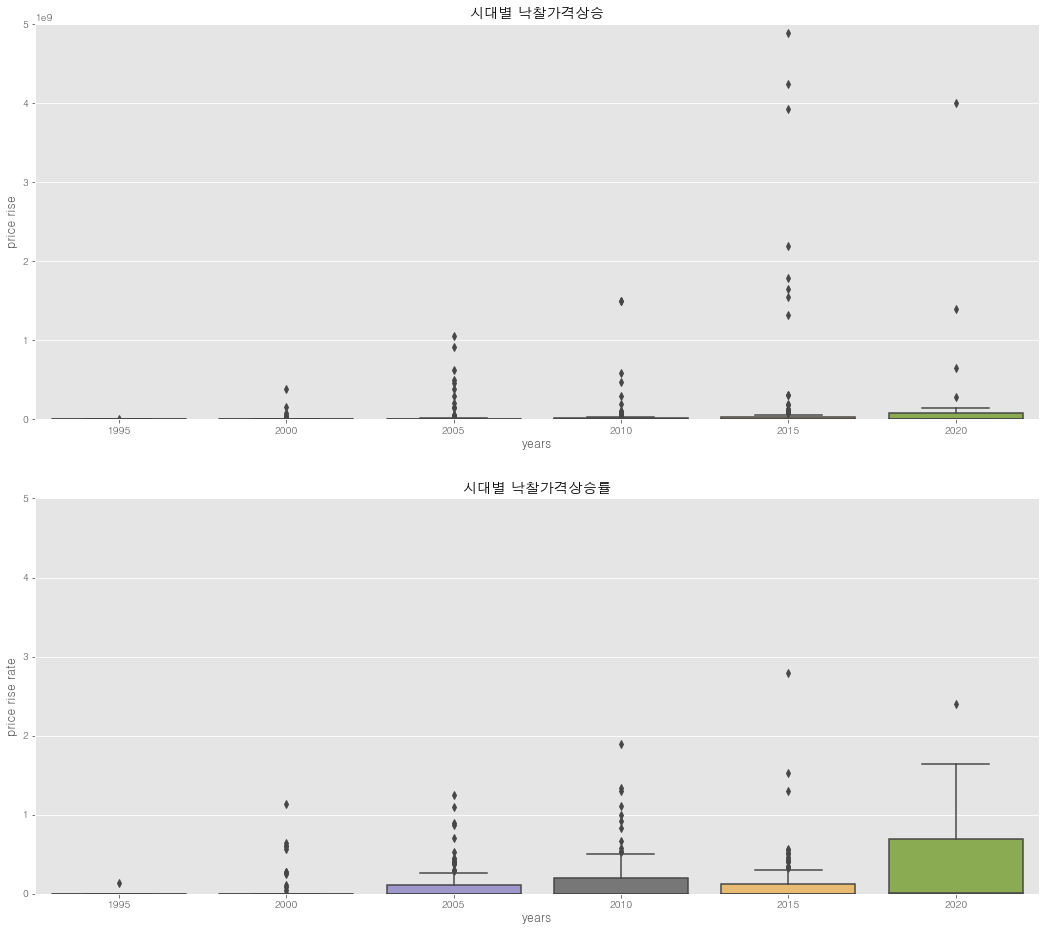

In [42]:
fig, axes = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(18, 16)

sns.boxplot(data=train,y="price_rise",x="5year",orient="v",ax=axes[0])
sns.boxplot(data=train,y="price_rise_rate",x="5year",orient="v",ax=axes[1])

axes[0].set(xlabel='years', ylabel='price rise', title="시대별 낙찰가격상승",ylim=(0,0.5e10))
axes[1].set(xlabel='years', ylabel='price rise rate',title="시대별 낙찰가격상승률",ylim=(0,5))


In [43]:
fig.savefig('savefig_default.png')

In [44]:
# //*[@id="container"]/div[3]/div/form/fieldset/div/div[1]/div[2]/dl[1]/dd/div/input[1]
#container > div.contents_wrap > div > form > fieldset > div > div.btn_wrap > span.btn_style01.gray02 > button


# resp = requests.get(url, data={'searchContent':artist})
# html_src = resp.text
# soup = BeautifulSoup(html_src, 'html.parser')

# soup
#container > div.contents_wrap > div > form > fieldset > div > div.search_box > div:nth-child(2) > dl:nth-child(1) > dd > div > input:nth-child(1)

# subway_image = soup.select('#mw-context-text > div > table:nth-child(3) > tbody > tr:nth-child(2) > td > a > img')
#mw-content-text > div.mw-parser-output > table:nth-child(3) > tbody > tr:nth-child(1) > td > a > img

# subway_image = soup.select('tr > td > a > img')
# print(subway_image)

# xpath, 조금 더 간결하게 접근이 가능함
# soup.XPath('//*[@id="mw-content-text"]/div[1]/table[1]/tbody/tr[1]/td/a/img')

# #siteNotice : ID selector .mw-headline class를 의미 tag와 함께 사용할 수 있음

# id_selector = soup.select('#siteNotice')
# print(id_selector)


#auctionList > li:nth-child(5) > div.result_auction_img_wrap.ng-scope > div > a > span > img

#container > div.contents_wrap > div > form > div > div.left > div > paging > ul > li:nth-child(14) > a